<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/epacuit/introduction-machine-learning/blob/main/classification/example-classifying-reviews.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(classifying-movie-reviews)=
# Example: Classifying Movie Reviews

This example is taken from Section 4.1 of the book "Deep Learning with Python" by François Chollet.

The IMDB dataset contains a set of 50,000 highly polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

We will train a model to classify movie reviews as positive or negative, based on the text content of the reviews.

## Step 1: Load the data

In [1]:
from tensorflow.keras.datasets import imdb 

(train_data, train_labels), (test_data, test_labels) = imdb.load_data( num_words=10000)

`train_data` and `test_data`: lists of reviews, each review being a list of word indices (encoding a sequence of words).

`train_labels` and `test_labels`: lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive".

In [2]:
review_idx = 0
print(train_data[review_idx])
print(train_labels[review_idx])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


The `imbdb` object has a method `get_word_index` that returns a dictionary mapping words to an integer index.

In [3]:
review_idx = 2
word_index = imdb.get_word_index() 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 

# Note that the indices are offset by 3 because 0, 1, and 2 are 
# reserved indices for “padding,” “start of sequence,” and “unknown.”
decoded_review = " ".join([reverse_word_index.get(i-3, "?") 
                           for i in train_data[review_idx]])

print(f"Review index: {review_idx}")
print(f"Review data:\n{train_data[review_idx]}")
print(f"Review:\n{decoded_review}")
print(f"Label: {train_labels[review_idx]}")

Review index: 2
Review data:
[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2401, 311, 12, 16, 3711, 33, 75, 43, 1829, 296, 4, 86, 320, 35, 534, 19, 263, 4821, 1301, 4, 1873, 33, 89, 78, 12, 66, 16, 4, 360, 7, 4, 58, 316, 334, 11, 4, 1716, 43, 645, 662, 8, 257, 85, 1200, 42, 1228, 2578, 83, 68, 3912, 15, 36, 165, 1539, 278, 36, 69, 2, 780, 8, 106, 14, 6905, 1338, 18, 6, 22, 12, 215, 28, 610, 40, 6, 87, 326, 23, 2300, 21, 23, 22, 12, 272, 40, 57, 31, 11, 4, 22, 47, 6, 2307, 51, 9, 170, 23, 595, 116, 595, 1352, 13, 191, 79, 638, 89, 2, 14, 9, 8, 106, 607, 624, 35, 534, 6, 227, 7, 129, 113]
Review:
? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying 

In [4]:
# the words indices range from 1 to 9999
print(min(min(seq) for seq in train_data))
print(max(max(seq) for seq in train_data))

print(reverse_word_index[1])
print(word_index["the"])


1
9999
the
1


## Step 2: Preprocess the data

In this step, we will convert the lists of integers into tensors that our neural network can process. 

We will implement **multi-hot-encoding** - a binary representation commonly used in NLP - to transform our lists into vectors of 0s and 1s. Each resulting tensor will be a 10,000-element vector where:

* 1 indicates the word appears in the review
* 0 indicates the word is absent

This representation creates a standardized format that our model can efficiently process while preserving the essential information about word presence in each review.



In [5]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) 
    for i, sequence in enumerate(sequences):
        for j in sequence:  
            results[i, j] = 1.
    return results 

x_train = vectorize_sequences(train_data) 
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32") 
y_test = np.asarray(test_labels).astype("float32")

In [6]:

# check that the vectorized data is correct
for i in train_data[0]: 
    if x_train[0, i] != 1.0: 
        print(f"i={i} x_train[0, {i}]={x_train[0, i]}")

# test your understanding: why are these values not the same? 
print(sum(x_train[0]))
print(len(train_data[0]))


120.0
218


## Step 3: Build the model

In [7]:
from tensorflow import keras 
from tensorflow.keras.layers import Dense

model = keras.Sequential([
    Dense(16, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## Step 4: Train the model

To train the model, we will use the `rmsprop` optimizer and the `binary_crossentropy` loss function. We will also monitor accuracy during training.  In addition, we will create a validation set by setting apart 10,000 samples from the original training data.

Here is an outline of the training loop:

0. Given the model, learning_rate, batch_size, epochs, train_data, train_labels, test_data, and test_labels
1. Initialize the optimizer with learning_rate
2. For each epoch from 1 to epochs
    1. Initialize an empty list of training losses
    2. For each batch of training data of size batch_size
        1. Extract the inputs and targets
        2. Do a forward pass through the model
        4. Calculate the loss
        5. Backward pass by updating the weights
        6. Append the loss to the list of training losses
    3. Initialize an empty list of validation losses
    4. For each batch of validation data
        1. Extract the inputs and targets
        2. Do a forward pass through the model
        3. Calculate the loss
        4. Append the loss to the list of validation losses
    5. Calculate and print the average training loss
    6. Calculate and print the average validation loss

#### Batch size

The `batch_size` parameter is a crucial hyperparameter that determines how many examples are processed together in a single forward/backward pass:

- Instead of updating model weights after each individual example (inefficient) or after the entire dataset (memory-intensive), we update after each batch
- Each batch contains exactly `batch_size` examples (except possibly the last batch, which might be smaller)
- The model weights are updated once per batch, not once per example
- Smaller batch sizes mean more frequent weight updates but with noisier gradients
- Larger batch sizes mean fewer weight updates per epoch but with more stable gradients

#### Validation Process

For validation, the entire validation set is evaluated, but still processed in batches for memory efficiency:

- The validation data is processed in batches of size `batch_size`, just like training data
- All validation samples are evaluated and their metrics averaged together
- Unlike training, no weight updates occur during validation
- The final validation metric represents performance across the entire validation set
- Validation typically happens once per epoch, not after every training batch

This approach enables evaluation on large validation sets that might not fit into memory all at once, while still getting a complete measure of model performance on the entire validation dataset.


In [8]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will train the model for 20 epochs in mini-batches of 512 samples.

In [9]:
history = model.fit(partial_x_train,
                    partial_y_train, 
                    epochs=20, 
                    batch_size=512, 
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6758 - loss: 0.6165 - val_accuracy: 0.8632 - val_loss: 0.4471
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8821 - loss: 0.3974 - val_accuracy: 0.8740 - val_loss: 0.3498
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9168 - loss: 0.2851 - val_accuracy: 0.8875 - val_loss: 0.3006
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9372 - loss: 0.2193 - val_accuracy: 0.8848 - val_loss: 0.2876
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9464 - loss: 0.1835 - val_accuracy: 0.8875 - val_loss: 0.2762
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9567 - loss: 0.1525 - val_accuracy: 0.8808 - val_loss: 0.3006
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9564 - loss: 0.1417 - val_accuracy: 0.8839 - val_loss: 0.2871
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9721 - loss: 0.1099 - val_accuracy: 0.8841 - val_loss

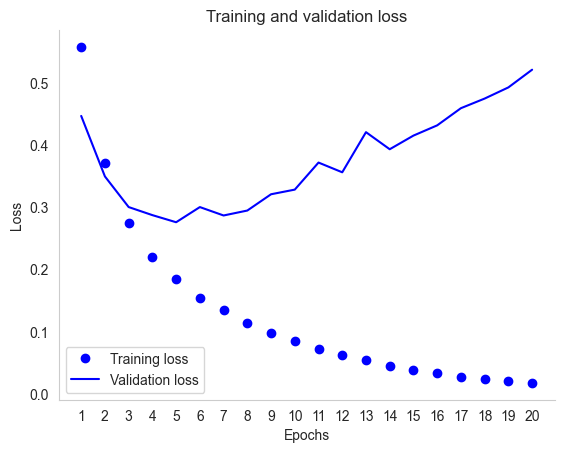

In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style("whitegrid")
history_dict = history.history

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, "bo", label="Training loss") 
plt.plot(epochs, val_loss_values, "b", label="Validation loss") 
plt.title("Training and validation loss") 
plt.xticks(epochs)
plt.xlabel("Epochs") 
plt.ylabel("Loss") 
plt.legend() 
sns.despine()
plt.grid(False)
plt.show()

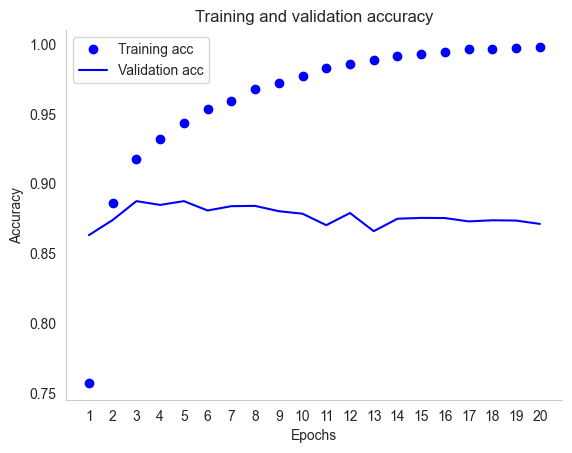

In [11]:
acc = history_dict["accuracy"]

val_acc = history_dict["val_accuracy"]

epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc") 
plt.title("Training and validation accuracy") 
plt.xticks(epochs)
plt.xlabel("Epochs") 
plt.ylabel("Accuracy") 
plt.legend() 
sns.despine()
plt.grid(False)
plt.show()

This shows that the model quickly starts overfitting the training data. Overfitting occurs when a model learns the training data too well, capturing not just the underlying patterns but also the random noise and peculiarities specific to the training set. We can identify overfitting by observing a characteristic divergence between training and validation metrics: while training loss continues to decrease, validation loss begins to increase or plateau.

Several indicators of overfitting in this case include:

* Decreasing training loss alongside increasing validation loss
* Growing gap between training and validation accuracy

This behavior suggests the model is becoming too specialized to the training examples rather than learning generalizable patterns. There are several strategies to mitigate overfitting, which we will explore later in the course.  In this case, we will stop training after 4 epochs to prevent overfitting.

In [12]:
model = keras.Sequential([
    Dense(16, activation="relu"),
    Dense(16, activation="relu"), 
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"])

model.fit(x_train, y_train, epochs=4, batch_size=512) 
results = model.evaluate(x_test, y_test)

print(f"The test loss is {results[0]}")
print(f"The test accuracy is {results[1]}")
print("The predictions are:")   
print(model.predict(x_test))

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7157 - loss: 0.5676
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - loss: 0.2932
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9257 - loss: 0.2175
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9368 - loss: 0.1836
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.8769 - loss: 0.3014
The test loss is 0.302092045545578
The test accuracy is 0.8773999810218811
The predictions are:
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
[[0.15246597]
 [0.9969948 ]
 [0.54584444]
 ...
 [0.09481005]
 [0.05016625]
 [0.35019177]]


Some things to try: 

* Try using different optimizers: `adam` or `sgd`
* Try using one or three representation layers, and see how doing so affects validation and test accuracy.
* Try using layers with more units or fewer units: 32 units, 64 units, and so on.
* Try using the `mse` loss function instead of `binary_crossentropy`.
* Try using the `tanh` activation instead of `relu`.

In [142]:
model = keras.Sequential([
    Dense(16, activation="relu"),
    Dense(16, activation="relu"), 
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"])

model.fit(x_train, y_train, epochs=4, batch_size=512) 
results = model.evaluate(x_test, y_test)

print(f"The test loss is {results[0]}")
print(f"The test accuracy is {results[1]}")
print("The predictions are:")   
print(model.predict(x_test))

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7334 - loss: 0.5589
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9013 - loss: 0.2803
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9284 - loss: 0.2119
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9412 - loss: 0.1748
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.8807 - loss: 0.2964
The test loss is 0.29562628269195557
The test accuracy is 0.8824800252914429
The predictions are:
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
[[0.16801447]
 [0.9994885 ]
 [0.77144325]
 ...
 [0.05713792]
 [0.03728548]
 [0.6995398 ]]
